In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Random seed for reproducibility
seed = 16

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
dataset_path = os.path.join('../input/anndlhw2/Training.csv')

In [4]:
X = np.genfromtxt('../input/anndlhw2/Training.csv',delimiter=',',skip_header=True)

In [5]:
# Pre-processing

X_max = X.max(axis=0)
X_min = X.min(axis=0)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X_scaled = (X-X_min)/(X_max-X_min)

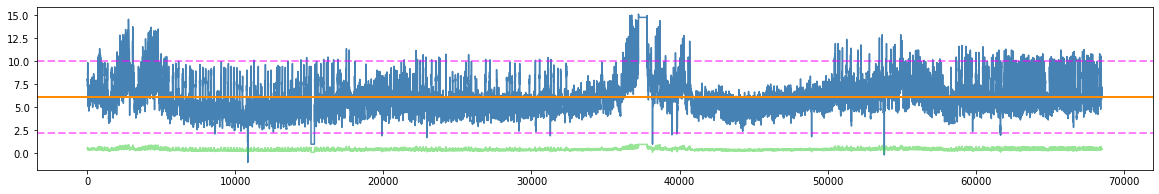

In [6]:
#for i in range(X.shape[-1]):
i=0
plt.figure(figsize=(20,3))
plt.plot(X[:,i],color='steelblue')
plt.plot(X_scaled[:,i],color='limegreen',alpha=.5)
plt.axhline(y=X_mean[i],color='darkorange',linewidth=2)
plt.axhline(y=X_mean[i]+2*X_std[i],color='magenta',alpha=.5,linestyle='--',linewidth=2)
plt.axhline(y=X_mean[i]-2*X_std[i],color='magenta',alpha=.5,linestyle='--',linewidth=2)

In [7]:
# generate X, y
def extract_sequences(array,sequence_length = 200,future=1,stride=1,shuffle=True,seed=1):
   
    X = []
    y = []
    for i in range(0,len(array),stride):
        if i+sequence_length+future < len(array):
            X.append(array[i:i+sequence_length])
            y.append(array[i+sequence_length:i+sequence_length+future])
    X = np.array(X)
    y = np.array(y)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(X)
        np.random.seed(seed)
        np.random.shuffle(y)
    return X, y

In [8]:
stride = 1
sequence_length = 200
future = 2
X_train, y_train = extract_sequences(X_scaled,sequence_length, future, stride)
X_train.shape,y_train.shape

((68326, 200, 7), (68326, 2, 7))

In [9]:
def build_conv(input_shape):


    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv1D(filters=16,kernel_size=3,dilation_rate=1,padding="causal",activation='relu')(input_layer)
    x = tfkl.Conv1D(filters=32,kernel_size=3,dilation_rate=2,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=64,kernel_size=3,dilation_rate=4,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=128,kernel_size=3,dilation_rate=8,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=256,kernel_size=3,dilation_rate=16,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=512,kernel_size=3,dilation_rate=32,padding="causal",activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x1 = tfkl.AveragePooling1D()(x)

    x1,h1,c1 = tfkl.LSTM(units=512,return_sequences = True,return_state=True)(x1,initial_state=[h1,c1])
    
    x = tfkl.Conv1D(filters=16,kernel_size=3,dilation_rate=1,padding="causal",activation='relu')(x1)
    x = tfkl.Conv1D(filters=32,kernel_size=3,dilation_rate=2,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=64,kernel_size=3,dilation_rate=4,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=128,kernel_size=3,dilation_rate=8,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=256,kernel_size=3,dilation_rate=16,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=512,kernel_size=3,dilation_rate=32,padding="causal",activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Add()([x1,x])
    x1 = tfkl.AveragePooling1D()(x)
    
    x1,h1,c1 = tfkl.LSTM(units=512,return_sequences = True,return_state=True)(x1)

    x = tfkl.Conv1D(filters=16,kernel_size=3,dilation_rate=1,padding="causal",activation='relu')(x1)
    x = tfkl.Conv1D(filters=32,kernel_size=3,dilation_rate=2,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=64,kernel_size=3,dilation_rate=4,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=128,kernel_size=3,dilation_rate=8,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=256,kernel_size=3,dilation_rate=16,padding="causal",activation='relu')(x)
    x = tfkl.Conv1D(filters=512,kernel_size=3,dilation_rate=32,padding="causal",activation='relu')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Add()([x1,x])
    x1 = tfkl.AveragePooling1D()(x)
    
    x1,h1,c1 = tfkl.LSTM(units=512,return_sequences = False,return_state=True)(x1,initial_state=[h1,c1])
       
    x = tfkl.Flatten()(x1)
    #x = tfkl.Concatenate()([tfkl.Flatten()(x), tfkl.Flatten()(x),tfkl.Flatten()(x2)])
    x = tfkl.Dense(256,activation='relu')(x)
    x = tfkl.Dropout(.2)(x)
    x = tfkl.Dense(7*future)(x)

    
    #x2 = tfkl.LSTM(units=256)(input_layer)
    
    output_layer = tfkl.Reshape((future,7))(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model

In [10]:
input_shape = X_train.shape[1:]

model = build_conv(input_shape)
model.summary()

2022-01-19 08:27:06.997331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 08:27:07.109129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 08:27:07.109862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 08:27:07.110945: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 200, 7)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 200, 16)      352         Input[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 200, 32)      1568        conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 200, 64)      6208        conv1d_1[0][0]                   
______________________________________________________________________________________________

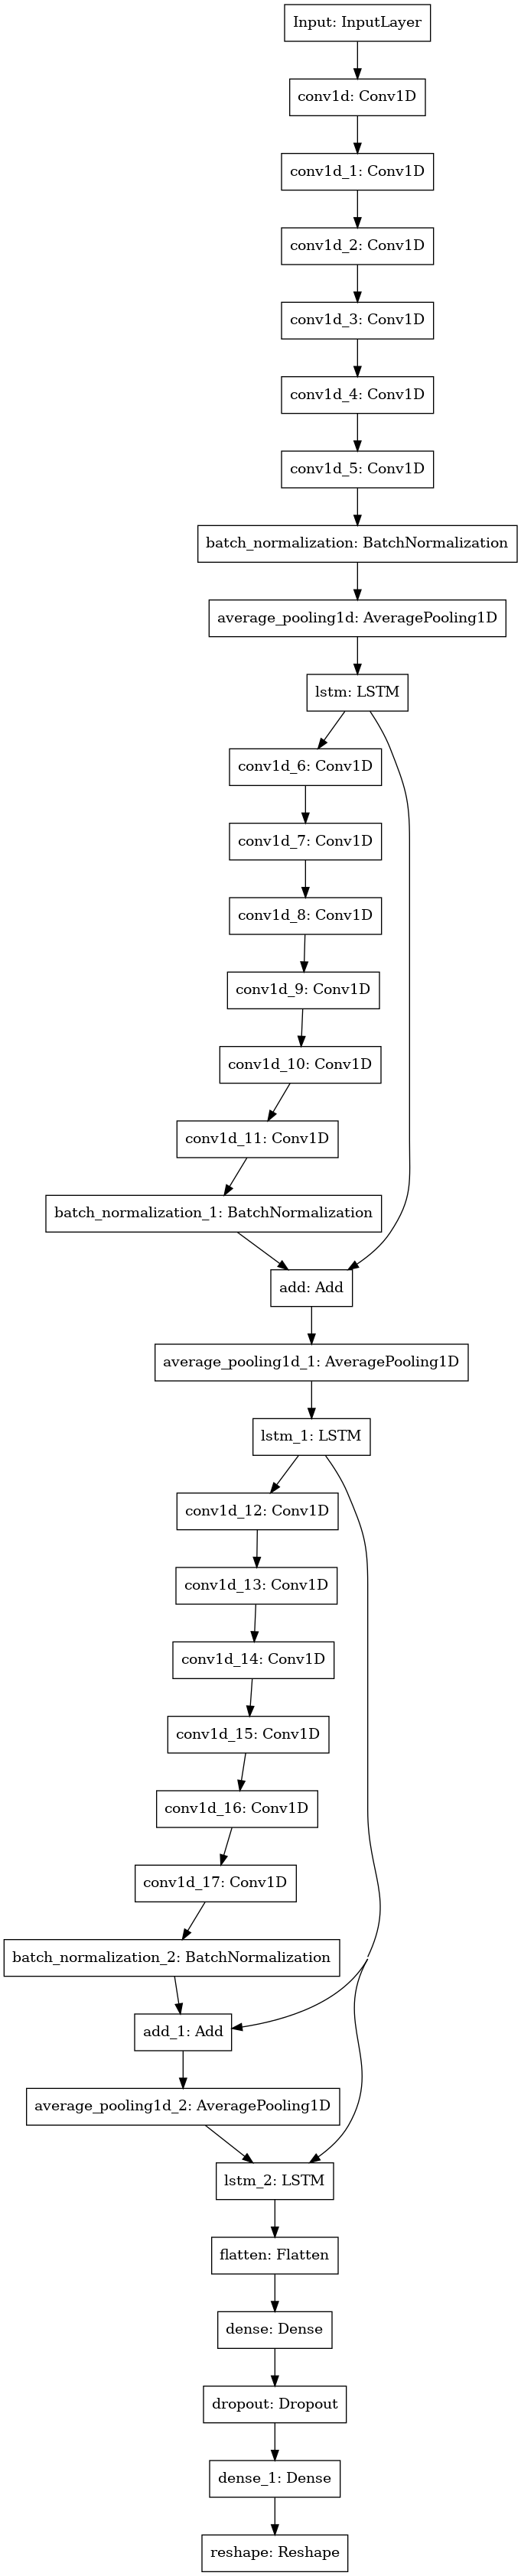

In [11]:
tfk.utils.plot_model(model, expand_nested=False)

In [12]:
epochs = 300
batch_size = 256

model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['mae'])

history = model.fit(
        X_train,
        y_train,
        validation_split=.1,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.7, min_lr=1e-5)
        ]
    ).history

2022-01-19 08:27:12.800688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-01-19 08:27:18.757046: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


241/241 [==============================] - 77s 268ms/step - loss: 0.0189 - mae: 0.0981 - val_loss: 0.0165 - val_mae: 0.0970
Epoch 2/300
241/241 [==============================] - 62s 258ms/step - loss: 0.0076 - mae: 0.0672 - val_loss: 0.0062 - val_mae: 0.0605
Epoch 3/300
241/241 [==============================] - 62s 258ms/step - loss: 0.0051 - mae: 0.0553 - val_loss: 0.0034 - val_mae: 0.0442
Epoch 4/300
241/241 [==============================] - 62s 258ms/step - loss: 0.0041 - mae: 0.0495 - val_loss: 0.0022 - val_mae: 0.0345
Epoch 5/300
241/241 [==============================] - 62s 258ms/step - loss: 0.0035 - mae: 0.0452 - val_loss: 0.0018 - val_mae: 0.0307
Epoch 6/300
241/241 [==============================] - 62s 258ms/step - loss: 0.0031 - mae: 0.0424 - val_loss: 0.0043 - val_mae: 0.0537
Epoch 7/300
241/241 [==============================] - 62s 258ms/step - loss: 0.0028 - mae: 0.0406 - val_loss: 0.0018 - val_mae: 0.0323
Epoch 8/300
241/241 [==============================] - 62s 2

In [13]:
future_window = 864

In [14]:
def autoregression_pred_multiout(model,window,future,future_window):
    last_window = X_scaled[-window:]
    last_window = np.expand_dims(last_window, axis=0)
    pred = model.predict(last_window)
    last_window.shape, pred.shape
    pred = np.array([])
    X_temp = last_window
    for t in range(0,future_window,future):
        pred_temp = model.predict(X_temp)
        #pred_temp = np.expand_dims(pred_temp, axis=0)
        if(len(pred)==0):
            pred = pred_temp
        else:
            pred = np.concatenate((pred,pred_temp),axis=1)
        X_temp = np.concatenate((X_temp[:,future:,:],pred_temp), axis=1)

    pred_scaled = pred[0]*(X_max-X_min)+X_min
    return pred_scaled

In [15]:
pred = autoregression_pred_multiout(model,sequence_length,future,future_window)

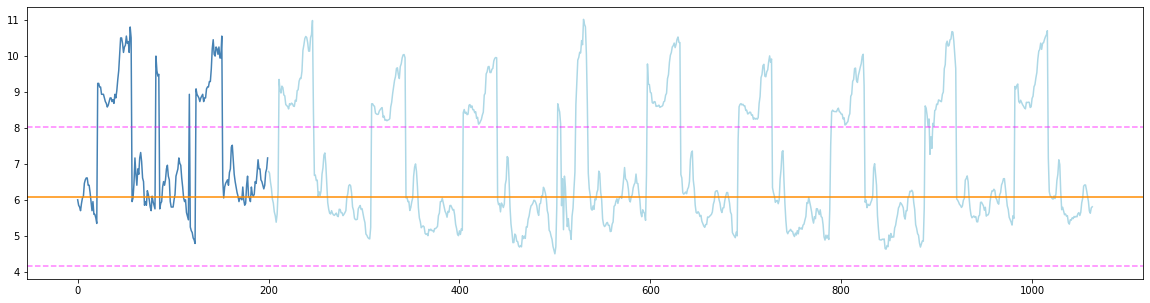

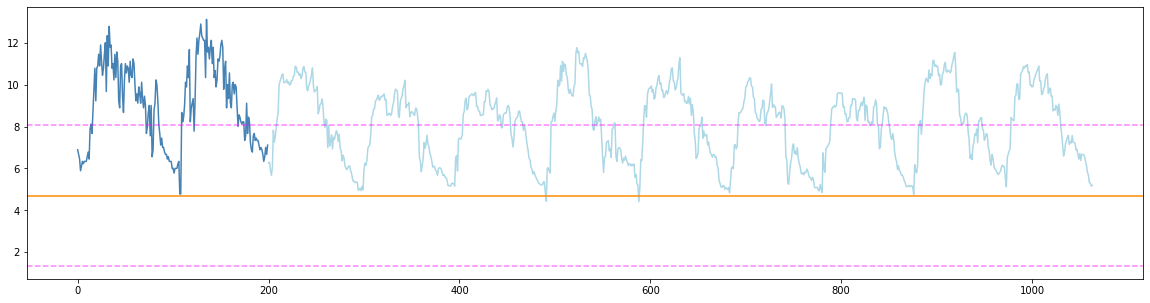

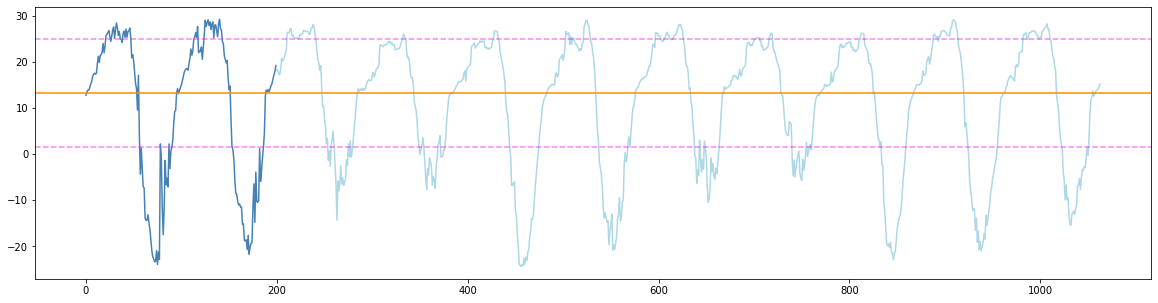

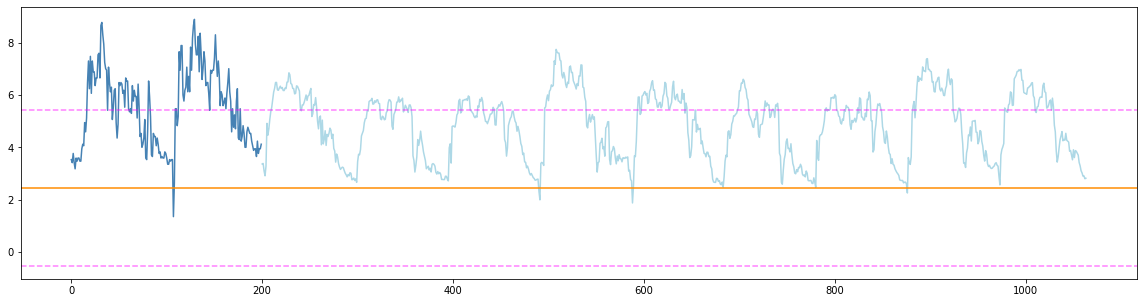

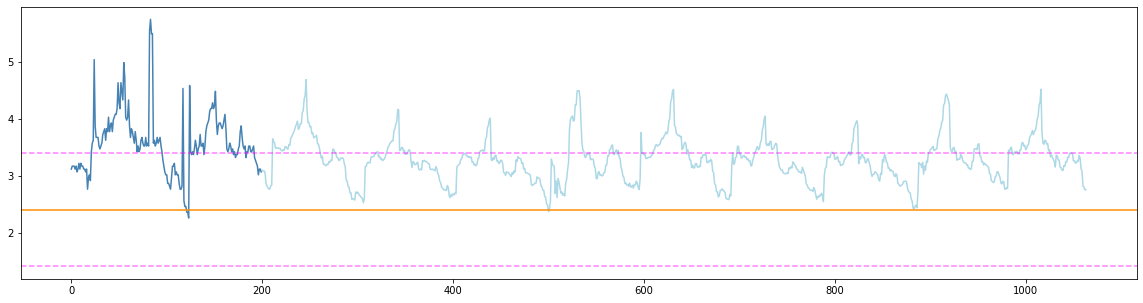

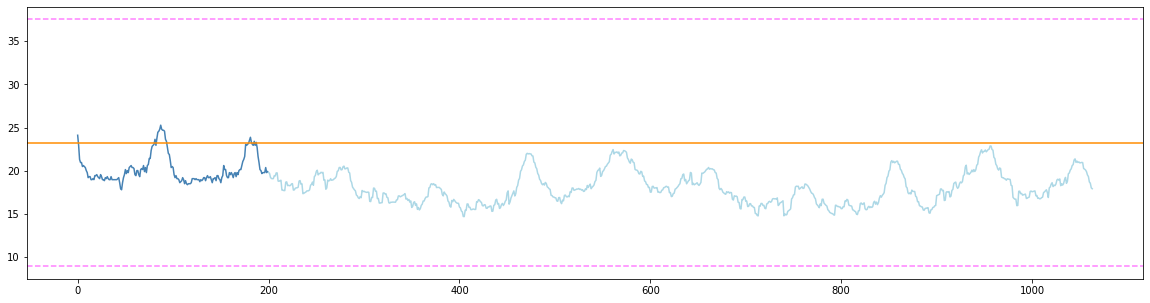

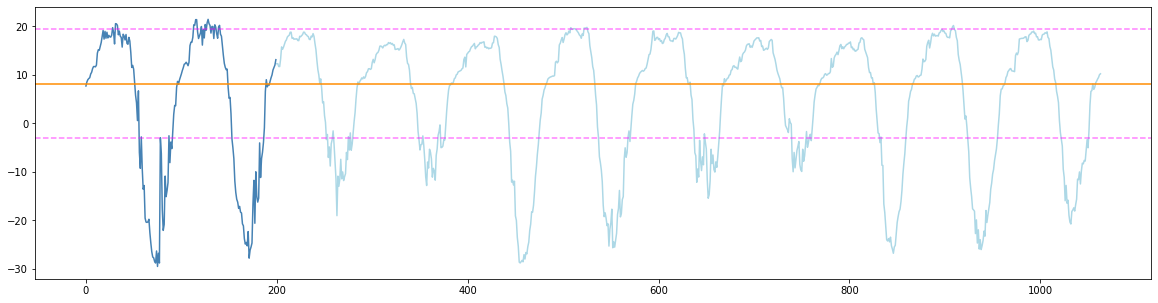

In [16]:
window = sequence_length
for i in range(pred.shape[-1]):
    plt.figure(figsize=(20,5))
    plt.plot(range(window),X[-window:,i],color='steelblue')
    plt.plot(range(window,window+future_window),pred[:,i],color='lightblue')
    plt.axhline(y=X_mean[i],color='darkorange',linestyle='-')
    plt.axhline(y=X_mean[i]+X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.axhline(y=X_mean[i]-X_std[i],color='magenta',linestyle='--',alpha=.5)

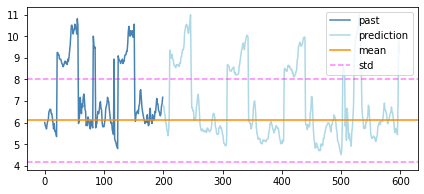

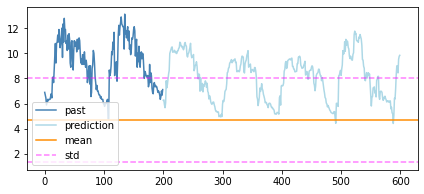

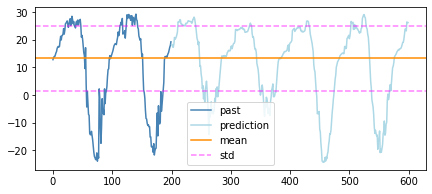

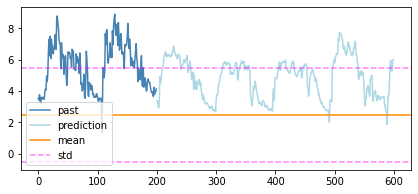

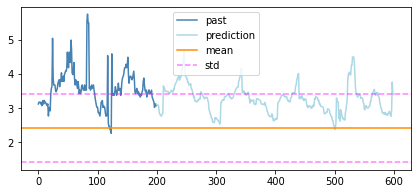

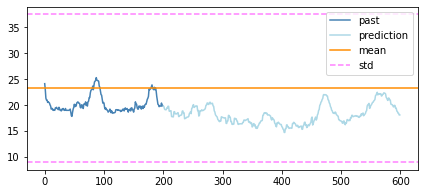

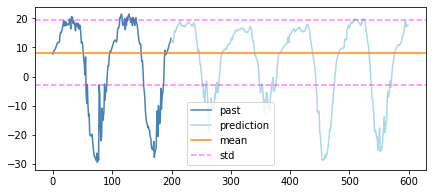

In [17]:
future_window = 400
window = sequence_length
for i in range(pred.shape[-1]):
    plt.figure(figsize=(7,3))
    plt.plot(range(window),X[-window:,i],color='steelblue',label='past')
    plt.plot(range(window,window+future_window),pred[:future_window,i],color='lightblue',label='prediction')
    plt.axhline(y=X_mean[i],color='darkorange',linestyle='-',label='mean')
    plt.axhline(y=X_mean[i]+X_std[i],color='magenta',linestyle='--',alpha=.5,label='std')
    plt.axhline(y=X_mean[i]-X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.legend()

In [18]:
#for i in range(pred_scaled.shape[-1]):
#    plt.figure(figsize=(20,5))
#    plt.plot(range(window),train_scaled[-window:,i])
#    plt.plot(range(window,window+future_window),val_scaled[:future_window,i])
#    plt.plot(range(window,window+future_window),pred[0,:,i])


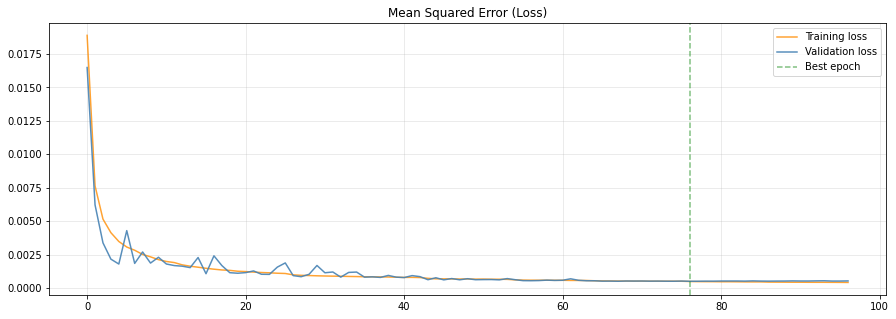

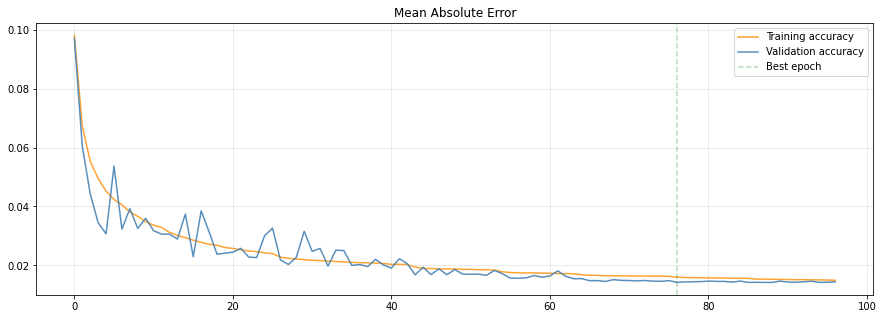

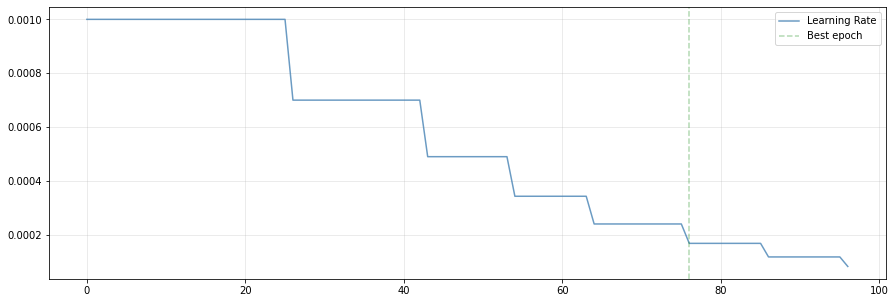

In [19]:
best_epoch = np.argmin(history['val_loss'])
fig_size = (15,5)
plt.figure(figsize=fig_size)
plt.plot(history['loss'], label='Training loss', alpha=.8, color='darkorange')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.5, ls='--', color='green')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='darkorange')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.legend()
plt.grid(alpha=.3)
plt.show()

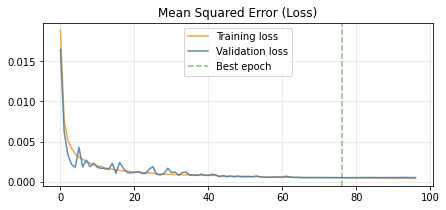

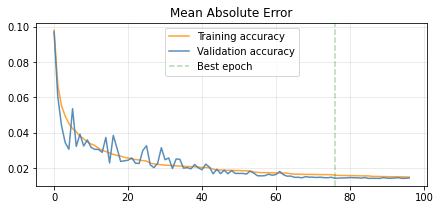

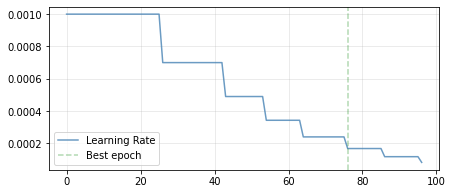

In [20]:
best_epoch = np.argmin(history['val_loss'])
fig_size = (7,3)
plt.figure(figsize=fig_size)
plt.plot(history['loss'], label='Training loss', alpha=.8, color='darkorange')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.5, ls='--', color='green')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='darkorange')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [21]:
# SCORE 3.9962544441

In [22]:
model.save('model')
#model = tfk.models.load_model('model')
!zip -r model.zip model

2022-01-19 10:09:09.947222: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


  adding: model/ (stored 0%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 95%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 76%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: model/saved_model.pb (deflated 89%)
